In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download the data (public github)
!wget -N https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz

--2024-11-25 13:02:58--  https://github.com/fiddler-labs/p2p-lending-data/raw/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz [following]
--2024-11-25 13:02:59--  https://media.githubusercontent.com/media/fiddler-labs/p2p-lending-data/refs/heads/master/raw_data/accepted_2007_to_2018Q3.csv.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370087868 (353M) [application/octet-stream]
Saving to: ‘accepted_2007_to_2018Q3.csv.gz’

accepted_2

In [3]:
#Read the compressed CSV file into a DataFrame
df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

In [4]:
#Check no of rows and columns in the dataframe
loan_df = pd.read_csv('accepted_2007_to_2018Q3.csv.gz')

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

Total Number of Rows: 2,132,287
Total Number of Columns: 151


In [5]:
# Step 2: Filter rows for specific loan statuses
sls_loan_df = loan_df[loan_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

print('Total Number of Rows:', '{:,}'.format(sls_loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(sls_loan_df.shape[1]))

Total Number of Rows: 1,266,618
Total Number of Columns: 151


In [6]:
import os
os.getcwd()

'/content'

In [7]:
# Cast the 'issue_d' column to datetime (if needed)
sls_loan_df['issue_d'] = pd.to_datetime(sls_loan_df['issue_d'])

# Save to a pickle file for faster future loading
sls_loan_df.to_pickle('/content/loan_df.pkl')

In [8]:
# Step 3: Sample a subset of the data for initial processing
sls_loan_df = sls_loan_df.sample(frac=0.05, random_state=0)

# Save to a pickle file for faster future loading
sls_loan_df.to_pickle('/content/loan_df_subset.pkl')

# Check the DataFrame
print(f'Total Rows: {sls_loan_df.shape[0]}, Total Columns: {sls_loan_df.shape[1]}')
print(sls_loan_df.head())



Total Rows: 63331, Total Columns: 151
               id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
185466   74622258        NaN     7000.0       7000.0           6850.0   
265659   68904823        NaN    12000.0      12000.0          12000.0   
1537243   3353615        NaN    24000.0      24000.0          24000.0   
1477946   6625164        NaN    35000.0      35000.0          35000.0   
1603538  68537494        NaN    14000.0      14000.0          14000.0   

               term  int_rate  installment grade sub_grade  ...  \
185466    36 months     19.53       258.48     D        D5  ...   
265659    36 months      7.49       373.22     A        A4  ...   
1537243   60 months     17.27       599.96     C        C5  ...   
1477946   36 months     17.56      1257.63     D        D1  ...   
1603538   36 months      5.32       421.61     A        A1  ...   

        hardship_payoff_balance_amount hardship_last_payment_amount  \
185466                             NaN           

In [9]:
def get_missing_values_table(loan_df):
    #Number of null values by column
    missing_values_df = pd.DataFrame(loan_df.isnull().sum(),columns=['Missing_Count'])

    #Portion of null values by column
    missing_values_df['Portion_Missing'] = missing_values_df['Missing_Count']/loan_df.shape[0]

    #Sort by Missing_Count
    missing_values_df = missing_values_df.sort_values(by='Missing_Count',ascending=False)

    return missing_values_df

missing_values_df = get_missing_values_table(sls_loan_df)
missing_values_df.head()

,Missing_Count,Portion_Missing
next_pymnt_d,63331,1.000000
member_id,63331,1.000000
orig_projected_additional_accrued_interest,63188,0.997742
sec_app_mths_since_last_major_derog,63101,0.996368
hardship_length,63100,0.996352


In [10]:
pd.set_option('display.max_columns', None)
print(df.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

Number of Columns with under 15% missing values: 93


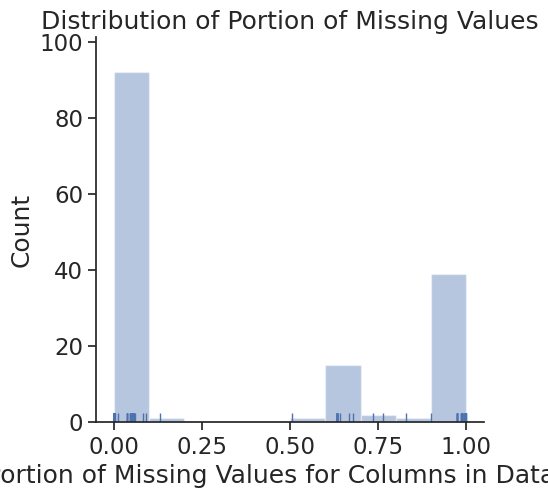

In [11]:
print('Number of Columns with under 15% missing values:',
      missing_values_df[missing_values_df['Portion_Missing']<=0.15].shape[0])

#Plot the distribution of Portions of missing values for the columns
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(missing_values_df['Portion_Missing'], bins=10, kde=False, rug=True)
ax.set_title('Distribution of Portion of Missing Values')
ax.set_xlabel('Portion of Missing Values for Columns in Dataset')
ax.set_ylabel('Count')
sns.despine()

In [12]:
missing_grp = missing_values_df[(missing_values_df['Portion_Missing']>=0.6)&(missing_values_df['Portion_Missing']<=0.7)]
display(missing_grp)

missing_columns = missing_grp.index

earliest_date = []
for column in missing_columns:
    earliest_date.append(min(sls_loan_df[~sls_loan_df[column].isnull()]['issue_d']))

display(pd.DataFrame({'Column':missing_columns,
                      'Earliest issue_d for which column value is not null':earliest_date}))

,Missing_Count,Portion_Missing
il_util,43040,0.679604
mths_since_recent_revol_delinq,42276,0.667540
mths_since_rcnt_il,40611,0.641250
all_util,40031,0.632092
total_cu_tl,40030,0.632076
max_bal_bc,40030,0.632076
inq_last_12m,40030,0.632076
open_rv_12m,40030,0.632076
total_bal_il,40030,0.632076
open_il_24m,40030,0.632076


,Column,Earliest issue_d for which column value is not null
0,il_util,2015-12-01
1,mths_since_recent_revol_delinq,2012-03-01
2,mths_since_rcnt_il,2015-12-01
3,all_util,2015-12-01
4,total_cu_tl,2015-12-01
5,max_bal_bc,2015-12-01
6,inq_last_12m,2015-12-01
7,open_rv_12m,2015-12-01
8,total_bal_il,2015-12-01
9,open_il_24m,2015-12-01


In [13]:
exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status' ]

potential_features = np.setdiff1d(sls_loan_df.columns.tolist(), exclude)

print(len(potential_features))
print(sorted(potential_features))

loan_df = sls_loan_df[potential_features]

88
['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_

In [14]:
def view_missingness_by_issue_d(df):
    missing_values_df = get_missing_values_table(df)
    earliest_date = []
    cols_with_missing_vals = missing_values_df[(missing_values_df.Portion_Missing<1) &
                                           (missing_values_df.Missing_Count >0)].index

    for column in cols_with_missing_vals:
        earliest_date.append(min(loan_df[~loan_df[column].isnull()]['issue_d']))

    df = pd.DataFrame({'Column':cols_with_missing_vals,
                      'Earliest issue_d for which column value is not null':earliest_date})

    return df.sort_values(by='Earliest issue_d for which column value is not null', ascending=False)

view_missingness_by_issue_d(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_mths_since_last_major_derog,2017-03-01
1,sec_app_revol_util,2017-03-01
2,sec_app_inq_last_6mths,2017-03-01
3,sec_app_open_act_il,2017-03-01
4,sec_app_open_acc,2017-03-01
5,sec_app_num_rev_accts,2017-03-01
6,sec_app_earliest_cr_line,2017-03-01
7,sec_app_collections_12_mths_ex_med,2017-03-01
8,sec_app_fico_range_low,2017-03-01
9,sec_app_fico_range_high,2017-03-01


In [15]:
coborrower_cols =  ['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
                    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
                    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
                    'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
                    'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), coborrower_cols)
loan_df = loan_df[potential_features]

In [16]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_fico_range_high,2017-03-01
1,sec_app_fico_range_low,2017-03-01
16,num_actv_rev_tl,2012-08-01
29,num_actv_bc_tl,2012-08-01
28,num_tl_op_past_12m,2012-08-01
27,num_tl_90g_dpd_24m,2012-08-01
26,tot_hi_cred_lim,2012-08-01
25,tot_cur_bal,2012-08-01
24,tot_coll_amt,2012-08-01
22,num_rev_tl_bal_gt_0,2012-08-01


,Missing_Count,Portion_Missing
sec_app_fico_range_high,62609,0.988600
sec_app_fico_range_low,62609,0.988600
mths_since_last_record,52542,0.829641
mths_since_recent_bc_dlq,48435,0.764791
mths_since_last_major_derog,46643,0.736496
mths_since_recent_revol_delinq,42276,0.667540
mths_since_last_delinq,32047,0.506024
mths_since_recent_inq,8311,0.131231
mo_sin_old_il_acct,5212,0.082298
emp_length,3545,0.055976


In [17]:
print("Number of rows in dataset: {}".format (loan_df.shape[0]))

loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]


print("Number of rows in dataset after removing loans issued prior to 2012-08-01: {}"\
      .format (loan_df.shape[0]))

Number of rows in dataset: 63331
Number of rows in dataset after removing loans issued prior to 2012-08-01: 60141


In [18]:
display(view_missingness_by_issue_d(loan_df))

get_missing_values_table(loan_df).head(15)

,Column,Earliest issue_d for which column value is not null
0,sec_app_fico_range_high,2017-03-01
1,sec_app_fico_range_low,2017-03-01
20,num_op_rev_tl,2012-08-01
21,num_il_tl,2012-08-01
22,num_actv_rev_tl,2012-08-01
23,num_accts_ever_120_pd,2012-08-01
24,num_actv_bc_tl,2012-08-01
25,num_bc_tl,2012-08-01
26,num_rev_tl_bal_gt_0,2012-08-01
27,total_rev_hi_lim,2012-08-01


,Missing_Count,Portion_Missing
sec_app_fico_range_high,59419,0.987995
sec_app_fico_range_low,59419,0.987995
mths_since_last_record,49524,0.823465
mths_since_recent_bc_dlq,45245,0.752315
mths_since_last_major_derog,43453,0.722519
mths_since_recent_revol_delinq,39284,0.653198
mths_since_last_delinq,29958,0.498129
mths_since_recent_inq,5833,0.096989
emp_length,3453,0.057415
mo_sin_old_il_acct,2022,0.033621


In [19]:
#emp_length
print('emp_length value counts: \n{}\n'.format(loan_df.emp_length.value_counts()))

emp_length value counts: 
emp_length
10+ years    19998
2 years       5349
< 1 year      4835
3 years       4736
1 year        3883
5 years       3702
4 years       3592
8 years       2809
6 years       2797
7 years       2604
9 years       2383
Name: count, dtype: int64



In [20]:
def process_emp_length(df):
    df_new = df.copy()
    #0-1 years inclues: null, None, < 1 year, 1 year
    df_new['emp_length'] = df_new['emp_length'].fillna('0-1 years')
    df_new['emp_length'] = np.where(df_new['emp_length'].isin([np.nan,None,'< 1 year','1 year']),
                                     '0-1 years',df_new['emp_length'])
    #2-4 years inclues: 2 years, 3 years, 4 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['2 years','3 years','4 years']),
                                     '2-4 years',df_new['emp_length'])

    #5-9 years inclues: 5 years, 6 years, 7 years, 8 years, 9 years
    df_new['emp_length'] = np.where(df_new['emp_length'].isin(['5 years','6 years','7 years','8 years','9 years']),
                                     '5-9 years',df_new['emp_length'])
    #10+ years includes 10+ years (no change)
    return df_new

def process_revol_util(df):
    df_new = df.copy()

    df_new['revol_util'] = df_new['revol_util'].fillna(-100)
    df_new['revol_util'] = df_new['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_new['revol_util'] = np.where(df_new['revol_util']==-1.0,np.nan,df_new['revol_util'])

    return df_new

def process_month_since_cols(df):
    df_new = df.copy()

    mo_since_cols = ['mo_sin_old_il_acct','mths_since_last_delinq','mths_since_last_major_derog',
                     'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_inq',
                     'mths_since_recent_revol_delinq','mo_sin_old_rev_tl_op','mths_since_recent_bc',
                     'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']

    for col in mo_since_cols:
        df_new[col].fillna(df_new[col].max()+1, inplace=True)

    return df_new

def process_loan_grades(df):
    df_new = df.copy()

    # turn sub_grade into ordinal mapping
    sorted_subgrades = sorted(df.sub_grade.unique())
    subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
    df_new['sub_grade'] = df_new['sub_grade'].map(subgrade_dict)

    # turn grade into ordinal mapping
    sorted_grades = sorted(df.grade.unique())
    grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
    df_new['grade'] = df_new['grade'].map(grade_dict)
    return df_new


def process_loan_cols(df):
    df_processed = process_emp_length(df)
    df_processed = process_revol_util(df_processed)
    df_processed = process_month_since_cols(df_processed)
    df_processed = process_loan_grades(df_processed)

    #add credit_line_age
    df_processed['credit_line_age'] = df_processed['issue_d'] - pd.to_datetime(df_processed['earliest_cr_line'])
    df_processed = df_processed.drop(columns='earliest_cr_line')

    #process int_rate, zip_code, credit_line_age
    df_processed['int_rate'] = df_processed['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)
    df_processed['zip_code'] = df_processed['zip_code'].apply(lambda x: x[:3])
    df_processed['credit_line_age'] = df_processed['credit_line_age'].apply(lambda x: x.days)

    # generate new column for outcome variable ('fully_paid'); drop 'loan_status'
    df_processed['fully_paid'] = df_processed['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
    df_processed = df_processed.drop(columns='loan_status')

    return df_processed

loan_df = process_loan_cols(loan_df)

In [21]:
missing_data = get_missing_values_table(loan_df)
display(missing_data[missing_data.Missing_Count!=0])
missing_cols = missing_data[missing_data.Missing_Count!=0].index

print("datatypes of the columns that still have missing values: ")
print(loan_df[missing_cols].dtypes.unique().tolist())

,Missing_Count,Portion_Missing
sec_app_fico_range_low,59419,0.987995
sec_app_fico_range_high,59419,0.987995
bc_util,653,0.010858
percent_bc_gt_75,624,0.010376
bc_open_to_buy,609,0.010126
pct_tl_nvr_dlq,238,0.003957
tot_coll_amt,233,0.003874
num_actv_bc_tl,233,0.003874
num_bc_tl,233,0.003874
num_il_tl,233,0.003874


datatypes of the columns that still have missing values: 
[dtype('float64')]


In [22]:
#Rerun Types
types_df = pd.DataFrame(loan_df.dtypes,columns=['Types'])
display(types_df[types_df['Types']!='float64'].sort_values(by='Types'))


object_vars=loan_df.select_dtypes(include='object').columns.tolist()
object_vars = np.setdiff1d(object_vars,['addr_state', 'zip_code'])
print(object_vars)

#Dummy encoding
loan_df = pd.get_dummies(loan_df,columns=object_vars,drop_first=True)

,Types
grade,int64
issue_d,datetime64[ns]
sub_grade,int64
credit_line_age,int64
fully_paid,int64
addr_state,object
application_type,object
emp_length,object
home_ownership,object
purpose,object


['application_type' 'emp_length' 'home_ownership' 'purpose' 'term'
 'verification_status']


In [23]:
#columns where imputation is neededpd.
missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

#verify they're all continuous dtypes appropriate for linear regression imputation
loan_df[missing_cols].dtypes.unique() # all float64

array([dtype('float64')], dtype=object)

In [24]:
def impute_missing_continuous(df, missing_columns, cols_to_exclude):
    clean_df = df.copy()

    for column in missing_columns:
        types_df = pd.DataFrame(df.dtypes, columns=['Types'])

        # Remove response variable and exclude specified columns
        impute_train = clean_df[~clean_df[column].isnull()].drop(cols_to_exclude, axis=1).sample(frac=0.1, random_state=12)

        # Split target
        X_impute_train = impute_train.drop(column, axis=1)
        Y_impute_train = impute_train[column]

        # Mean Imputation for current nulls for columns that did not get imputed yet
        X_impute_train = X_impute_train.fillna(X_impute_train.mean())

        # Train LinearRegression
        impute_ols = LinearRegression(fit_intercept=True)
        impute_ols.fit(X_impute_train, Y_impute_train)

        # Generate new temp column with model predictions
        # Only replace rows where the value is null with the predicted value
        predictions = clean_df.drop(cols_to_exclude + [column], axis=1)

        # Mean Imputation for current nulls for columns that did not get imputed yet
        predictions = predictions.fillna(predictions.mean())
        clean_df['temp'] = impute_ols.predict(predictions)

        clean_df[column] = np.where(clean_df[column].isnull(), clean_df['temp'], clean_df[column])
        clean_df = clean_df.drop('temp', axis=1)

    return clean_df

# Call the function
clean_df = impute_missing_continuous(
    loan_df,
    missing_columns=missing_cols,
    cols_to_exclude=['fully_paid', 'issue_d', 'zip_code', 'addr_state']
)


In [25]:
clean_df.isnull().values.any()

False

In [26]:
print("float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes=='float64'].index.tolist())

print("\nnon-float64 columns: ")
print(clean_df.dtypes[clean_df.dtypes!='float64'])

print("\n\nVisualizing unique values for non-float64 variables (except for zip_code and issue_d)")
for col in clean_df.dtypes[clean_df.dtypes!='float64'].index.tolist():
    if not col in['issue_d', 'zip_code']:
        print("\n", col)
        print(clean_df[col].unique())

float64 columns: 
['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'fico_range_high', 'fico_range_low', 'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'sec_app_fico_range_h

In [27]:
df.groupby(['loan_status']).size()

,0
loan_status,
Charged Off,254777
Current,822105
Default,32
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,1011841
In Grace Period,12458
Late (16-30 days),5442
Late (31-120 days),22852


In [28]:
clean_df.to_pickle('/content/clean_df_5pct_subset.pkl')

In [29]:
loan_df = pd.read_pickle('/content/loan_df.pkl')

exclude = ['id', 'member_id', 'url', 'next_pymnt_d', 'pymnt_plan', 'out_prncp',
           'out_prncp_inv', 'policy_code', 'open_acc_6m', 'open_act_il', 'open_il_12m',
           'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'il_util', 'all_util','mths_since_rcnt_il',
           'num_tl_120dpd_2m', 'num_tl_30dpd', 'deferral_term', 'hardship_amount',
           'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount',
           'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
           'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
           'orig_projected_additional_accrued_interest', 'payment_plan_start_date',
           'desc', 'title', 'emp_title', 'debt_settlement_flag', 'debt_settlement_flag_date',
           'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status',
           'settlement_term', 'recoveries', 'collection_recovery_fee', 'funded_amnt',
           'funded_amnt_inv', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',  'total_pymnt',
           'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
           'last_pymnt_d',  'last_credit_pull_d', 'disbursement_method', 'initial_list_status',
           'annual_inc_joint', 'dti_joint', 'revol_bal_joint','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
           'sec_app_mort_acc','sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
           'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
           'verification_status_joint']

potential_features = np.setdiff1d(loan_df.columns.tolist(), exclude)
loan_df = loan_df[potential_features]

loan_df = loan_df[loan_df['issue_d']>=datetime(2012,8,1)]

loan_df = process_loan_cols(loan_df)

object_vars = loan_df.select_dtypes(include='object').columns.tolist()
vars_for_dummies = np.setdiff1d(object_vars,['addr_state', 'zip_code'])

tmp_df = loan_df[vars_for_dummies]
loan_df = pd.get_dummies(loan_df,columns=vars_for_dummies,drop_first=True)

missing_cols = loan_df.columns[loan_df.isnull().any()].tolist()

clean_df = impute_missing_continuous(loan_df, missing_columns=missing_cols,
                                     cols_to_exclude=['fully_paid','issue_d', 'zip_code', 'addr_state'])

for col in vars_for_dummies:
    clean_df[col] = tmp_df[col]

print(sorted(clean_df.columns.tolist()))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'application_type_Joint App', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'credit_line_age', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'emp_length_10+ years', 'emp_length_2-4 years', 'emp_length_5-9 years', 'fico_range_high', 'fico_range_low', 'fully_paid', 'grade', 'home_ownership', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'n

In [30]:
# Showing where we are with the rows and columns we are left with
print(clean_df.shape)

(1203682, 99)


In [31]:
clean_df.to_pickle('clean_df.pkl')

In [32]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/content')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [34]:
loan_df = pd.read_pickle('/content/clean_df.pkl')

In [35]:
loan_df.groupby(['fully_paid']).size()

,0
fully_paid,
0,245205
1,958477


In [36]:
loan_df.fully_paid.value_counts(normalize = True)

,proportion
fully_paid,
1,0.796288
0,0.203712


In [37]:
# Stratified sampling to maintain proportions of 'fully_paid'
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

loan_df.fully_paid.value_counts(normalize = True)

,proportion
fully_paid,
1,0.79629
0,0.20371


Correlation Analysis

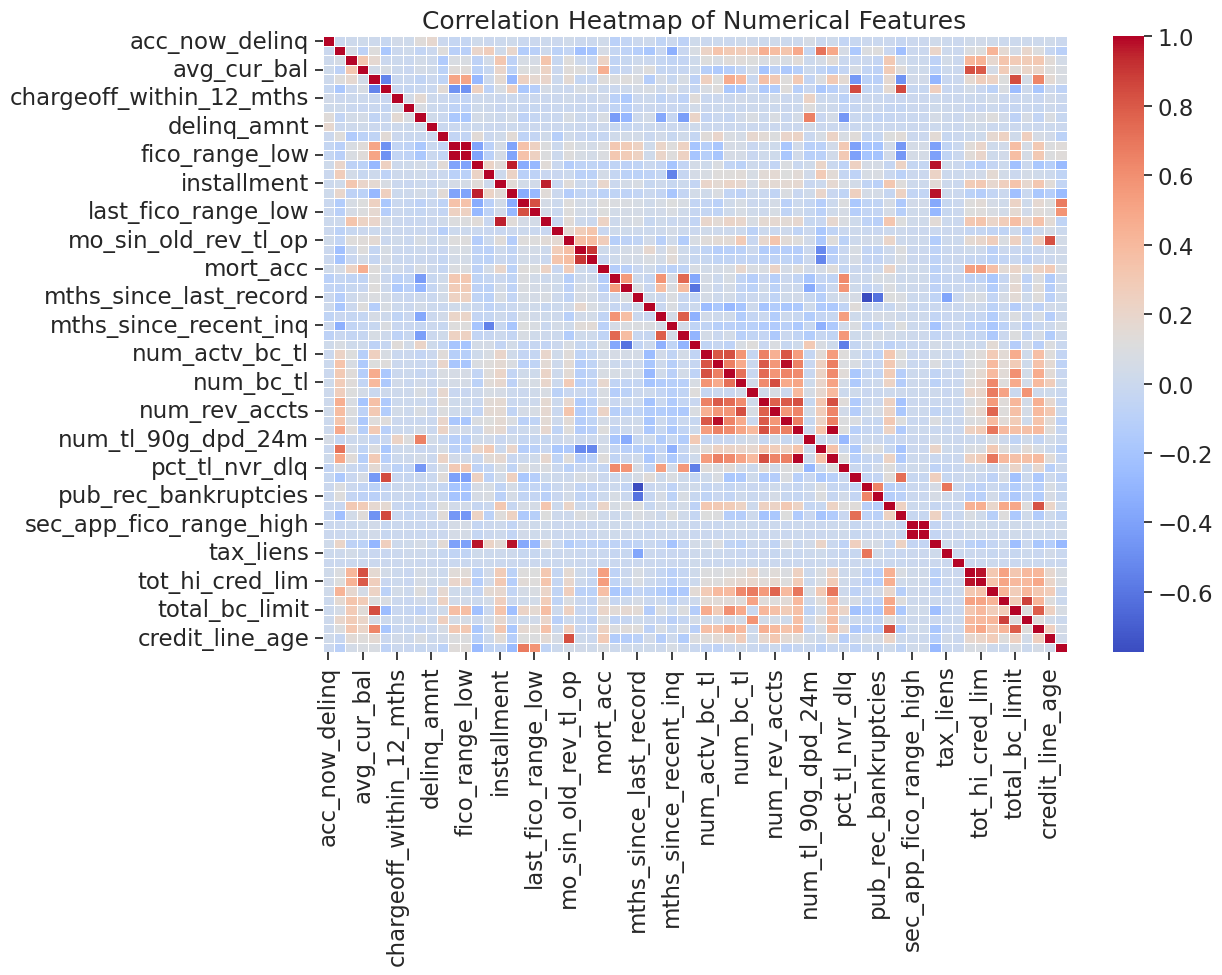

In [38]:
# Select numeric columns
numeric_columns = loan_df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix for numeric columns only
correlation_matrix = loan_df[numeric_columns].corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()



High Cardinality

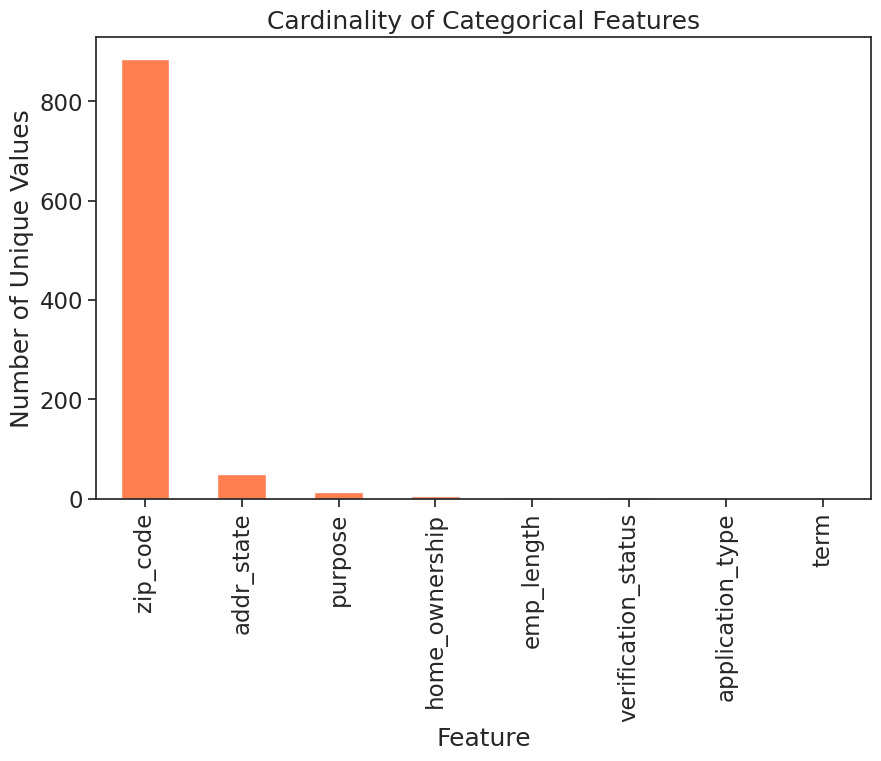

In [39]:
# Check unique values in categorical features
categorical_features = loan_df.select_dtypes(include=['object']).nunique()

# Plot cardinality
categorical_features.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color="coral")
plt.title("Cardinality of Categorical Features")
plt.xlabel("Feature")
plt.ylabel("Number of Unique Values")
plt.show()


 Variance Analysis

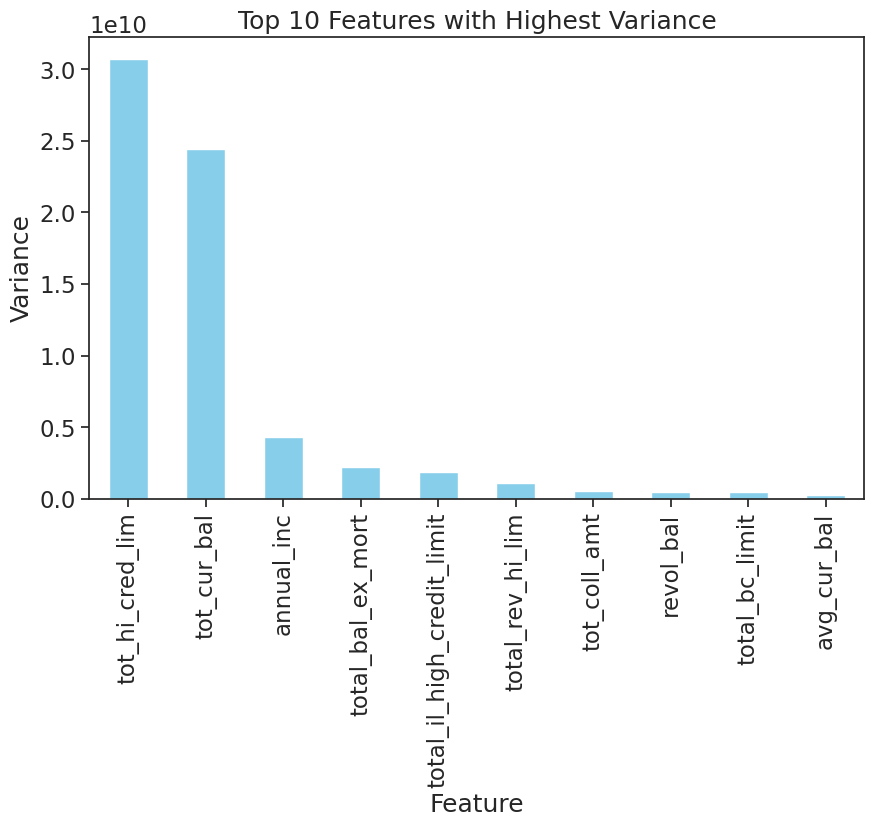

In [40]:
# Variance of numerical features
variances = loan_df.select_dtypes(include=['float64', 'int64']).var()

# Plot variance of top features
variances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6), color="skyblue")
plt.title("Top 10 Features with Highest Variance")
plt.xlabel("Feature")
plt.ylabel("Variance")
plt.show()


Dropping the columns

In [41]:
# Variables to drop based on our analysis
columns_to_drop = [
    'grade',  # Redundant as 'sub_grade' was more granular
    'sub_grade',  # Highly categorical; removed due to encoding complexity
    'installment',  # Correlated with 'loan_amnt'
    'int_rate',  # Highly correlated with 'fico_range_high'
    'zip_code',  # High cardinality, not directly related to loan repayment
    'issue_d',  # Date information unlikely to influence repayment
    'tot_hi_cred_lim',  # High variance but redundant with 'total_bc_limit'
    'tot_cur_bal',  # High variance but less informative compared to other balances
    'annual_inc',  # Less influential based on feature importance
    'total_rev_hi_lim',  # Redundant with 'total_bc_limit'
]

# Drop the selected columns
loan_df_cleaned = loan_df.drop(columns=columns_to_drop, errors='ignore')

# Verify the shape of the dataset after dropping columns
print(f"Original dataset shape: {loan_df.shape}")
print(f"Cleaned dataset shape: {loan_df_cleaned.shape}")

# Display the remaining columns
print("\nRemaining columns:")
print(loan_df_cleaned.columns)

Original dataset shape: (200000, 99)
Cleaned dataset shape: (200000, 89)

Remaining columns:
Index(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'fico_range_high', 'fico_range_low', 'inq_last_6mths',
       'last_fico_range_high', 'last_fico_range_low', 'loan_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op

Random Forest Classifier


Random Forest Performance (with Imbalanced Training Set):
Accuracy: 0.5017
ROC AUC: 0.9571

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      5000
           1       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.34     10000
weighted avg       0.75      0.50      0.34     10000



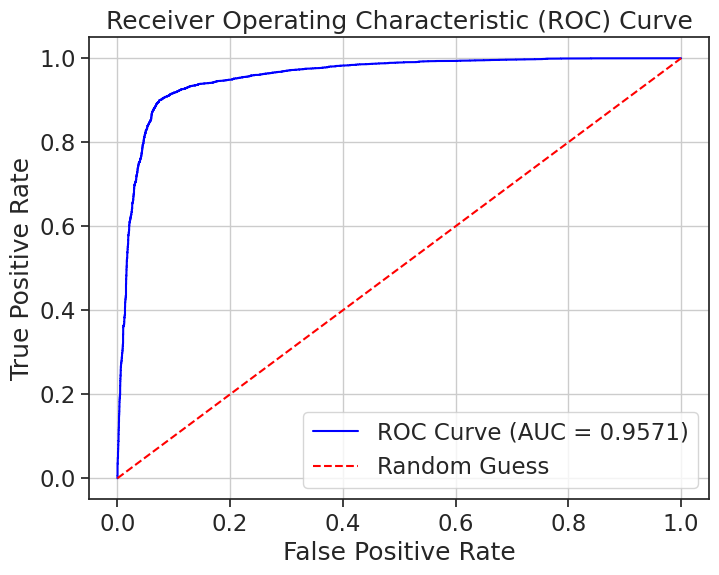

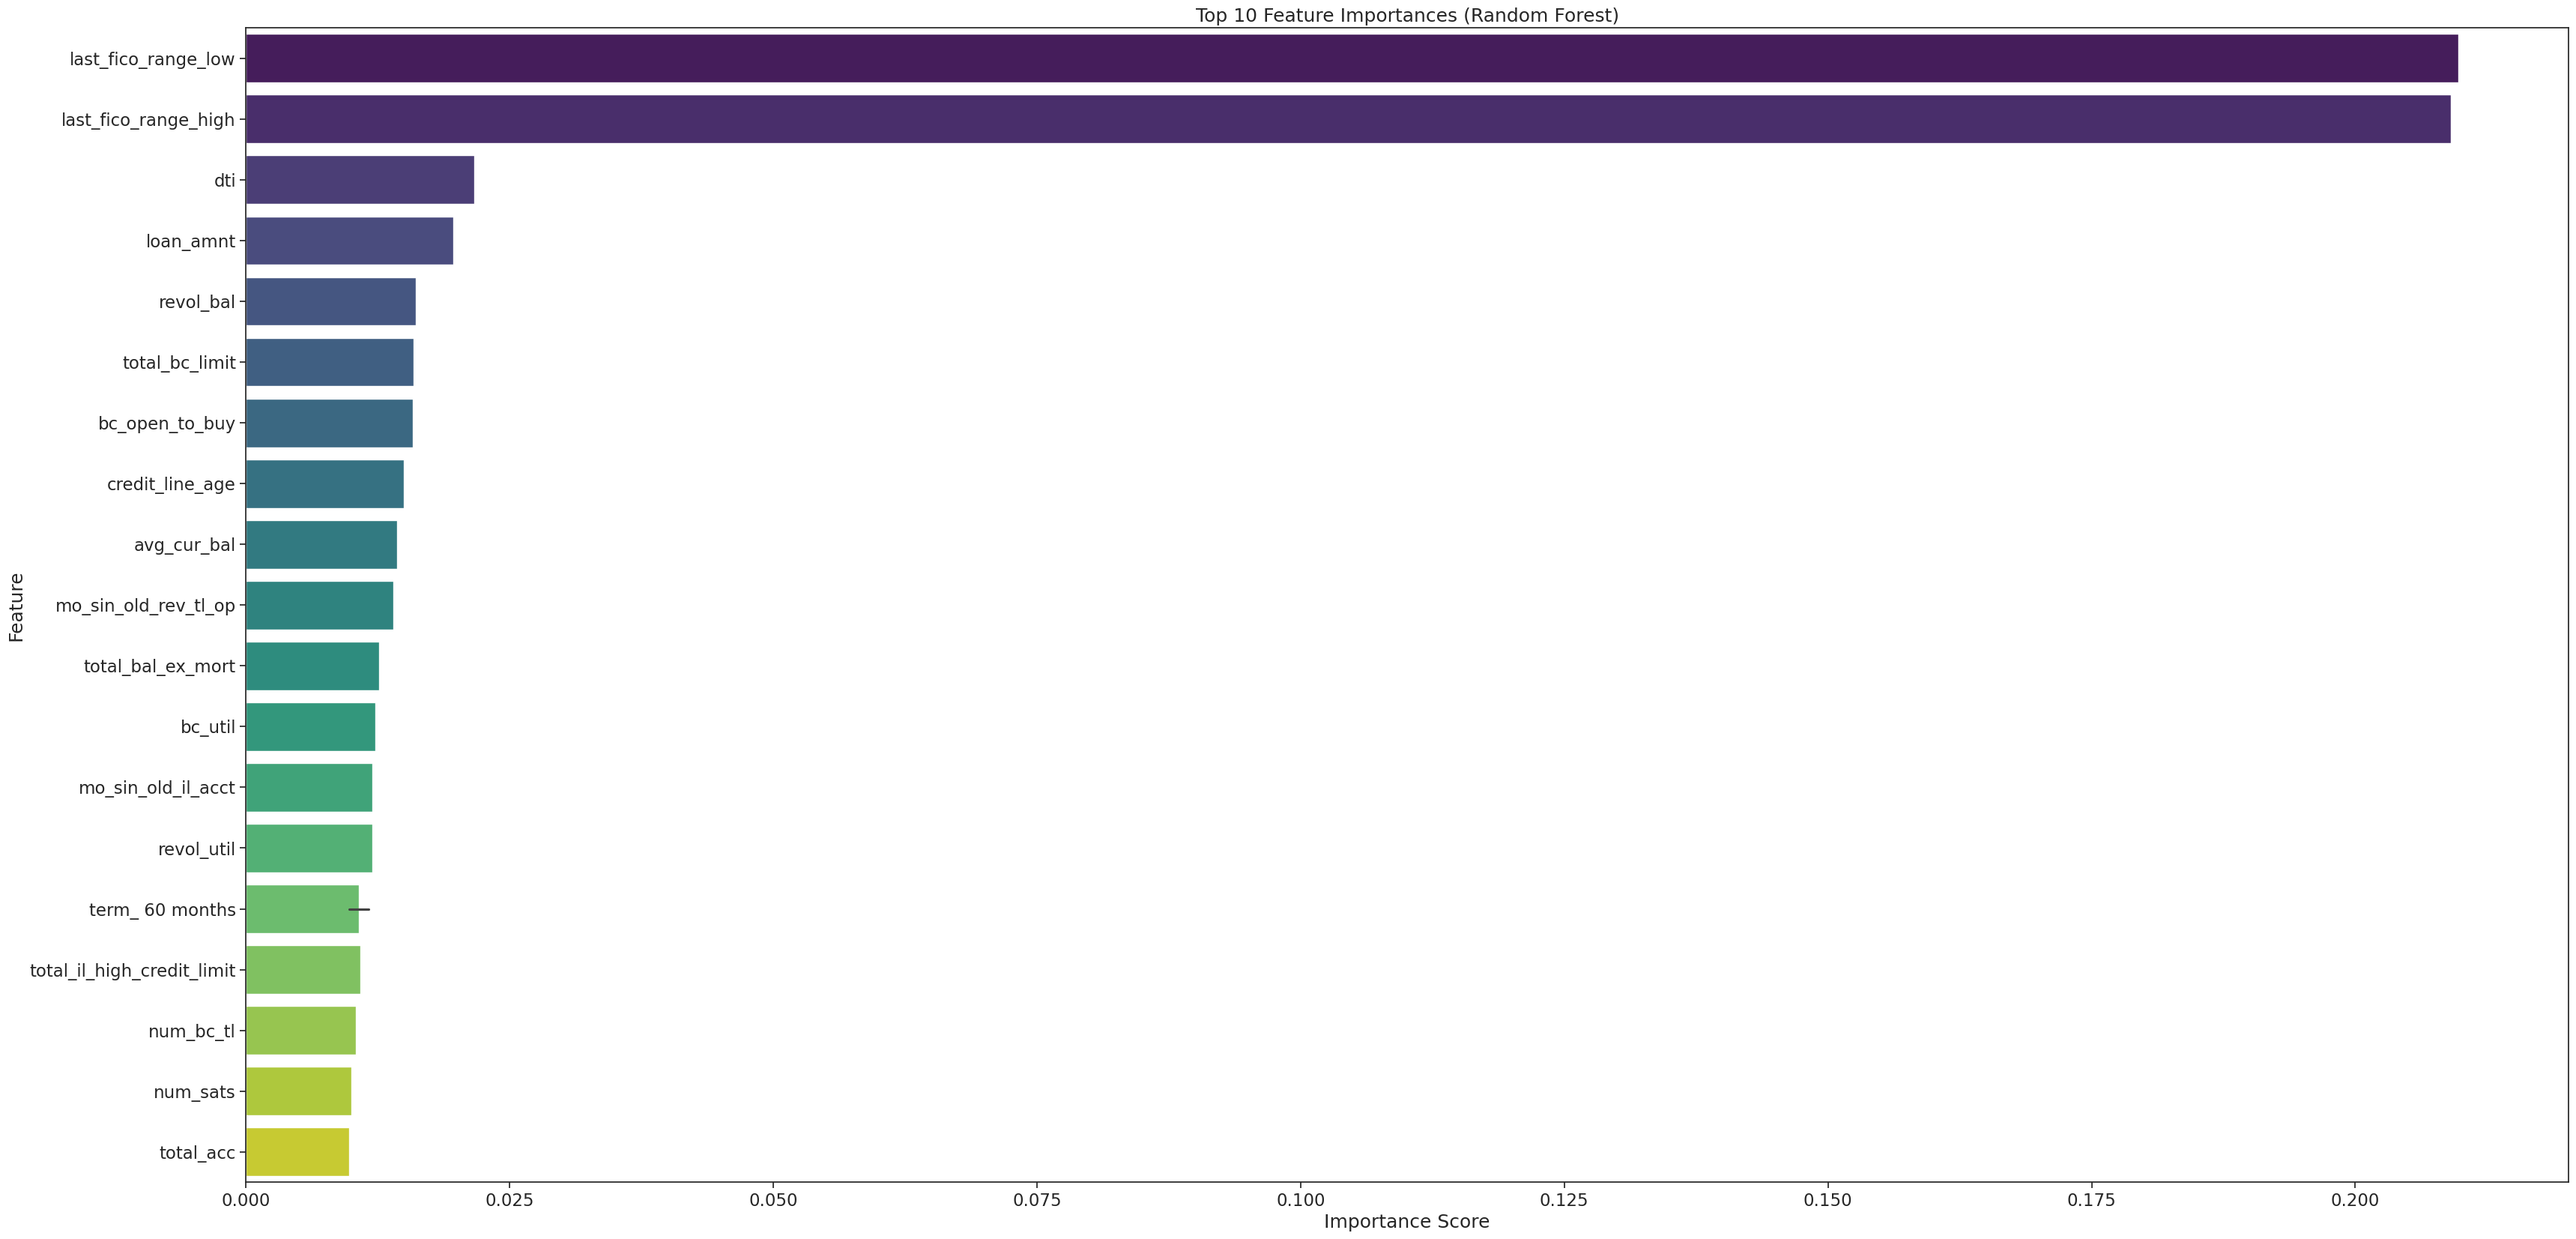

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column names are consistent
loan_df_cleaned.columns = loan_df_cleaned.columns.astype(str)

# Define features and target variable
X = loan_df_cleaned.drop(columns=['fully_paid'], errors='ignore')  # Features
y = loan_df_cleaned['fully_paid']  # Target variable

# Ensure all feature column names are strings
X.columns = X.columns.astype(str)

# Identify categorical columns in the dataset
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Introduce Train-Test Split ----------
train_majority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 1].sample(frac=0.95, random_state=42)
train_minority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 0].sample(frac=0.05, random_state=42)
train_data = pd.concat([train_majority, train_minority])
X_train = train_data.drop(columns=['fully_paid'], errors='ignore')
y_train = train_data['fully_paid']

# Step 2: Create a balanced test set (50% '1', 50% '0')
test_majority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 1].sample(n=5000, random_state=42)
test_minority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 0].sample(n=5000, random_state=42)
test_data = pd.concat([test_majority, test_minority])
X_test = test_data.drop(columns=['fully_paid'], errors='ignore')
y_test = test_data['fully_paid']

# Ensure one-hot encoding is applied to training and test data
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align the train and test feature sets (to ensure matching columns)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_encoded, y_train)

# Make predictions
y_pred = rf.predict(X_test_encoded)
y_proba = rf.predict_proba(X_test_encoded)[:, 1]

# Evaluate the model
print("\nRandom Forest Performance (with Imbalanced Training Set):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot feature importance
importances = rf.feature_importances_
features = X_train_encoded.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(40, 20))
sns.barplot(x=importances[indices][:20], y=features[indices][:20], palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [43]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(rf, 'random_forest_model_f.pkl')

print("Model saved as random_forest_model_f.pkl")

Model saved as random_forest_model_f.pkl


XGB with flaw

[0]	train-auc:0.80004	test-auc:0.94500
[1]	train-auc:0.80262	test-auc:0.94705
[2]	train-auc:0.80390	test-auc:0.94748
[3]	train-auc:0.80627	test-auc:0.94840
[4]	train-auc:0.80738	test-auc:0.94901
[5]	train-auc:0.80889	test-auc:0.94924
[6]	train-auc:0.81105	test-auc:0.94923
[7]	train-auc:0.81268	test-auc:0.94915
[8]	train-auc:0.81397	test-auc:0.94941
[9]	train-auc:0.81575	test-auc:0.94929
[10]	train-auc:0.81678	test-auc:0.94943
[11]	train-auc:0.81801	test-auc:0.94939
[12]	train-auc:0.81945	test-auc:0.94917
[13]	train-auc:0.82148	test-auc:0.94923
[14]	train-auc:0.82243	test-auc:0.94931
[15]	train-auc:0.82341	test-auc:0.94927
[16]	train-auc:0.82449	test-auc:0.94916
[17]	train-auc:0.82617	test-auc:0.94878
[18]	train-auc:0.82692	test-auc:0.94858
[19]	train-auc:0.82771	test-auc:0.94852
[20]	train-auc:0.82866	test-auc:0.94825

XGBoost Performance (with Flawed Labels):
Accuracy: 0.9081
ROC AUC: 0.9483

Classification Report:
              precision    recall  f1-score   support

           0   

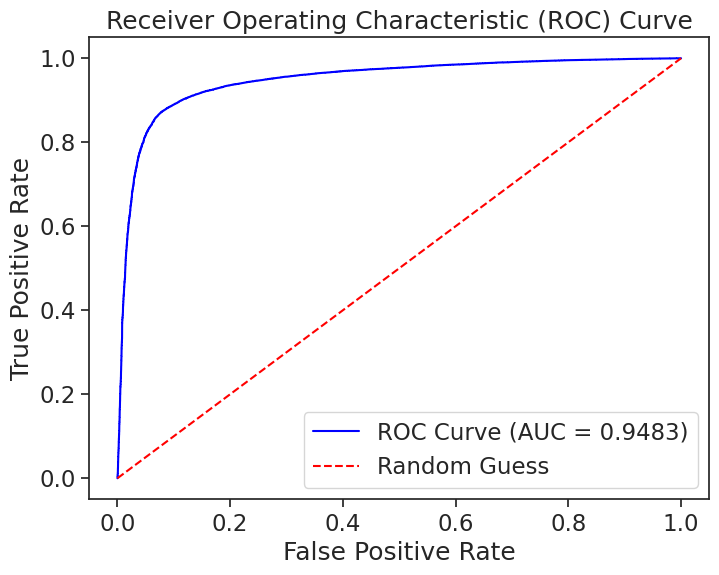

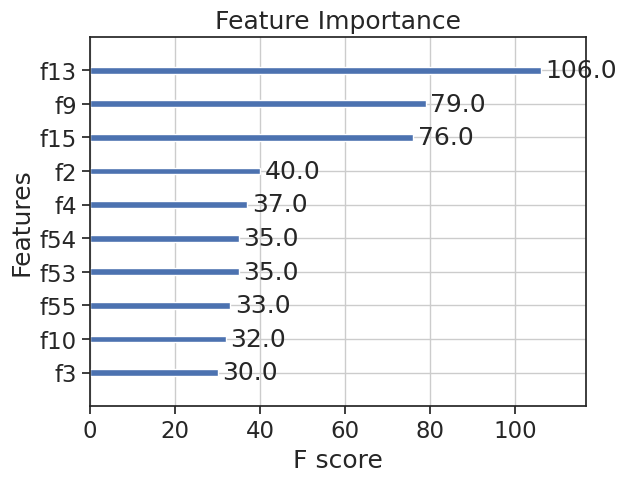

                       Feature  Importance
11        last_fico_range_high       106.0
8                          dti        79.0
12                   loan_amnt        76.0
2                  avg_cur_bal        40.0
4                      bc_util        37.0
..                         ...         ...
58         purpose_credit_card         1.0
40                     pub_rec         1.0
35          num_tl_90g_dpd_24m         1.0
5   collections_12_mths_ex_med         1.0
89               addr_state_WA         1.0

[90 rows x 2 columns]


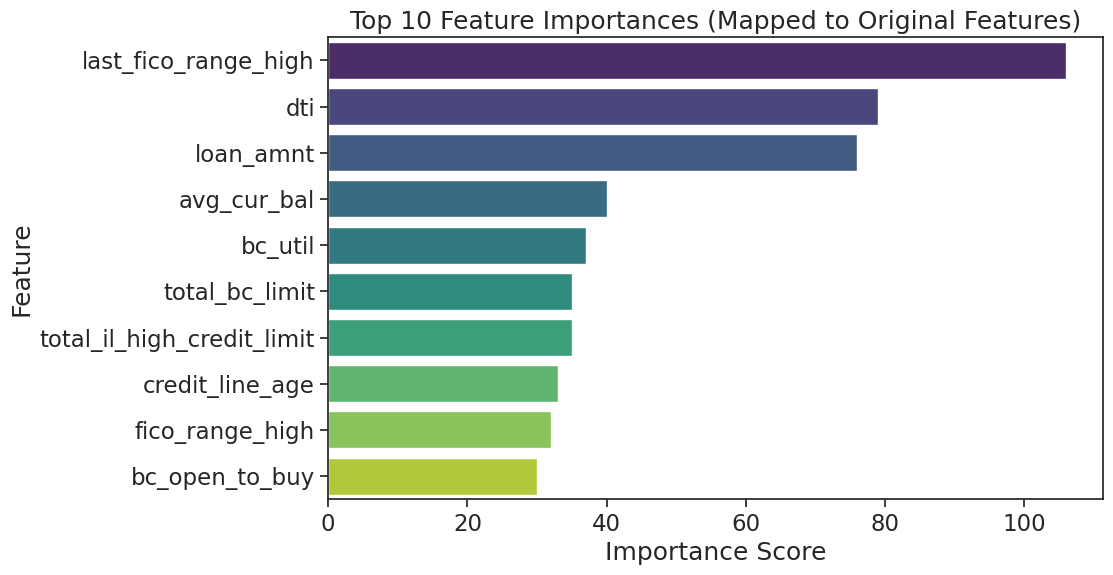

In [44]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define features and target variable
X = loan_df_cleaned.drop(columns=['fully_paid'], errors='ignore')  # Features
y = loan_df_cleaned['fully_paid']  # Target variable

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all columns are numeric
X = X.astype(float)

# Convert boolean columns to integers
X = X.astype({col: 'int' for col in X.select_dtypes('bool').columns})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Flip a portion of the labels in y_train --------
y_train = y_train.reset_index(drop=True)  # Reset index to ensure alignment with numpy indexing
flipped_indices = np.random.choice(y_train.index, size=int(0.1 * len(y_train)), replace=False)
y_train[flipped_indices] = 1 - y_train[flipped_indices]  # Flip 1 to 0 and 0 to 1

# Convert data to Numpy arrays for XGBoost compatibility
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Convert to XGBoost DMatrix for better performance
train_matrix = xgb.DMatrix(data=X_train, label=y_train)
test_matrix = xgb.DMatrix(data=X_test, label=y_test)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "eta": 0.3,
    "seed": 42
}

# Train the model
eval_set = [(train_matrix, "train"), (test_matrix, "test")]
model = xgb.train(params, train_matrix, num_boost_round=100, evals=eval_set, early_stopping_rounds=10)

# Make predictions
y_pred = (model.predict(test_matrix) > 0.5).astype(int)
y_proba = model.predict(test_matrix)

# Evaluate the model
print("\nXGBoost Performance (with Flawed Labels):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(model, max_num_features=10, importance_type="weight", title="Feature Importance")
plt.show()

# Recreate X_train with column names for feature mapping
X_train = pd.DataFrame(X_train, columns=X.columns)

# Retrieve feature importance from the trained model
importances = model.get_score(importance_type='weight')

# Map feature indices (f0, f1, ...) to original column names
feature_importance_df = pd.DataFrame({
    'Feature': [X_train.columns[int(f[1:])] for f in importances.keys()],
    'Importance': importances.values()
}).sort_values(by='Importance', ascending=False)

# Display the feature importance as a DataFrame
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances (Mapped to Original Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()